**Data**

Human PBMCs - Human peripheral blood mononuclear cells

In [16]:
import mudatasets as mds
import muon as mu
mdata, _ = mds.load("pbmc10k_multiome", with_info=True, full=True)
mdata.var_names_make_unique()



■ File filtered_feature_bc_matrix.h5 from pbmc10k_multiome has been found at /home/hienntx6/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from pbmc10k_multiome has been found at /home/hienntx6/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from pbmc10k_multiome has been found at /home/hienntx6/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from pbmc10k_multiome has been found at /home/hienntx6/mudatasets/pbmc10k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from pbmc10k_multiome has been found at /home/hienntx6/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature

/home/hienntx6/.local/lib/python3.8/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/hienntx6/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5


/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hienntx6/.local/lib/python3.8/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /home/hienntx6/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /home/hienntx6/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz


In [17]:
mdata

MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [18]:
# Có 2 phương thức: rna và atac
# dữ liệu ATAC-seq cung cấp thông tin về mức độ truy cập của DNA tại các vùng cụ thể trong mẫu
# dữ liệu RNA-seq thường bao gồm thông tin về mức độ biểu thức gen
atac = mdata.mod["atac"]
rna = mdata.mod['rna']

In [20]:
atac

AnnData object with n_obs × n_vars = 11909 × 108377
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

**Quality Control**

Loại bỏ những tế bào không đạt chất lượng 

In [19]:
import scanpy as sc
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)


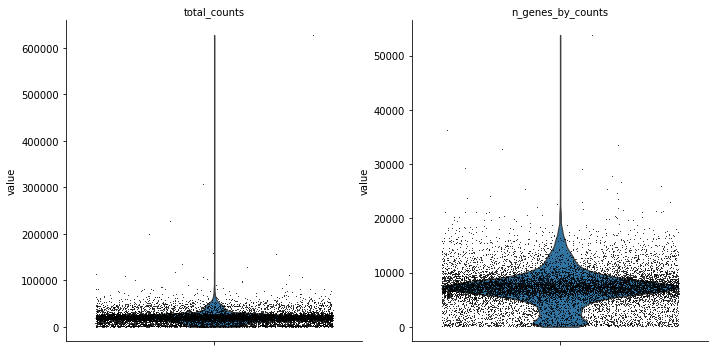

In [15]:
# total_counts: tổng số lượng đặc trưng (features) trong tế bào => mức độ hoạt động của tế bào
# n_genes_by_counts: độ phong phú của gene trong tế bào
sc.pl.violin(atac, ["total_counts", "n_genes_by_counts"], jitter=0.4, multi_panel=True)


In [21]:
# filter những tế bào có 2000 - 15000 genes
mu.pp.filter_obs(atac, "n_genes_by_counts", lambda x: (x >= 2000) & (x <= 15000))
# filter những tế bào có từ 4000 - 40000 features
mu.pp.filter_obs(atac, "total_counts", lambda x: (x >= 4000) & (x <= 40000))

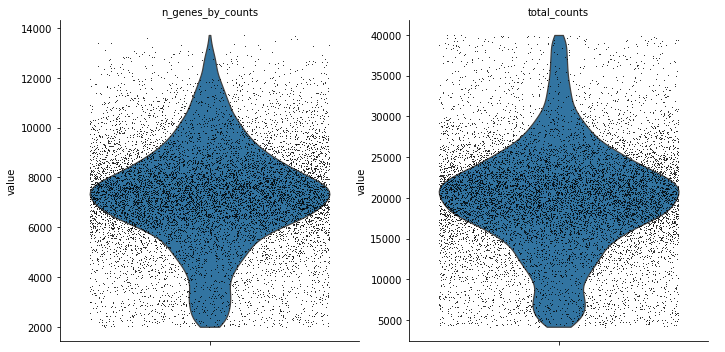

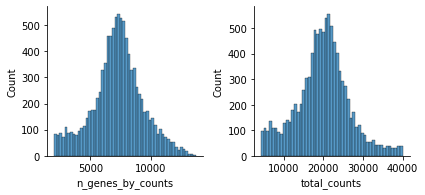

In [25]:
# Plot lại 
sc.pl.violin(atac, ["n_genes_by_counts", "total_counts"], jitter=0.4, multi_panel=True)
mu.pl.histogram(atac, ["n_genes_by_counts", "total_counts"])

Fetching Regions...: 100%|██████████| 1000/1000 [00:17<00:00, 57.96it/s]


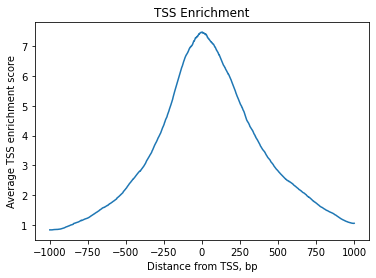

In [27]:
# Ước tính tín hiệu nucleosome từ tế bào
# Lấy thông tin về chú thích gen từ dữ liệu RNA
# Tính toán sự phong phú của transcription start site
from muon import atac as ac
atac.obs["NS"] = 1
ac.tl.nucleosome_signal(atac, n=1e6)
ac.tl.get_gene_annotation_from_rna(mdata["rna"]).head(3)
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)
ac.pl.tss_enrichment(tss)

In [28]:
# Lưu lại các thông tin: counts, normalize data và chọn các biến genes
atac.layers["counts"] = atac.X
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)
atac.raw = atac

In [32]:
ac.tl.lsi(atac)

In [33]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)


In [34]:
sc.tl.leiden(atac, resolution=0.5)


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


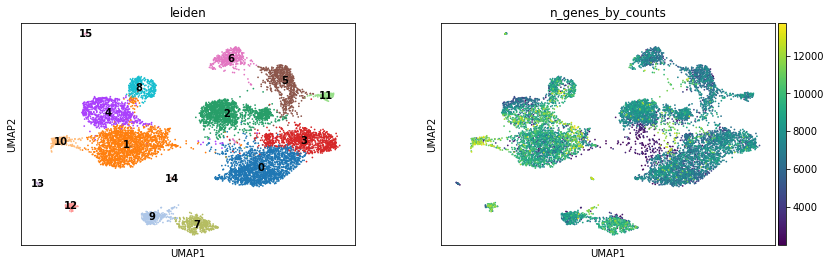

In [35]:
# Ưu điểm của umap so với các phương pháp khác (t-SNE,...): giữ được cấu trúc toàn cục khi giảm chiều + phân cụm chính xác
sc.tl.umap(atac, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")